# Structural Split Dataset

This shows how to load the structural holdout datasets described in Insert Section of our paper

There are two tar files you will need.  **The `StructureDataset` class will download these for you.**
- [The data splits](https://dl.fbaipublicfiles.com/fair-esm/structural-data/splits.tar.gz)
- [The pickle files containing sequence data, secondary structure labels, distance maps, and 3d coordinates](https://dl.fbaipublicfiles.com/fair-esm/structural-data/pkl.tar.gz)


In [1]:
import sys
PATH_TO_REPO = "../"
sys.path.append(PATH_TO_REPO)


In [2]:
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torch

import esm
from esm.data import ESMStructuralSplitDataset


# Loading the splits

Given the same root path, `ESMStructuralSplitDataset` will download the dataset only the first time it is initialized.  Any other time, it will check if the folder exists and exit early.

In [3]:
for split_level in ['family', 'superfamily', 'fold']:
    for cv_partition in ['0', '1', '2', '3', '4']:
        esm_structural_train = ESMStructuralSplitDataset(
            split_level=split_level, 
            cv_partition=cv_partition, 
            split='train', 
            root_path = os.path.expanduser('~/.cache/torch/data/esm'),
            download=True
        )
        esm_structural_valid = ESMStructuralSplitDataset(
            split_level=split_level, 
            cv_partition=cv_partition, 
            split='valid', 
            root_path = os.path.expanduser('~/.cache/torch/data/esm'),
            download=True
        )

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files alread

# Examine a single sample

Each element is a dict with
- `seq`    : string
- `ssp`    : string
- `dist`   : np.array
- `coords` : np.array

In [4]:
esm_structural_train = ESMStructuralSplitDataset(
    split_level='superfamily', 
    cv_partition='4', 
    split='train', 
    root_path = os.path.expanduser('~/.cache/torch/data/esm'),
    download=True
)
ele = esm_structural_train[0]
print(ele.keys()) 
print()
print('sequence', ele['seq'])
print()
print('SSP labels', ele['ssp'])


Files already downloaded and verified
dict_keys(['seq', 'ssp', 'dist', 'coords'])

sequence MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG

SSP labels XHHHHHHHHHHHHHHHHH-SS-B-HHHHHHHHTS-HHHHHHHHHHHHHHT---EEETTEEE--TT


## Visualize 3d Coordinates

In [5]:
coords = ele['coords']
xs = coords[:,0]
ys = coords[:,1]
zs = coords[:,2]

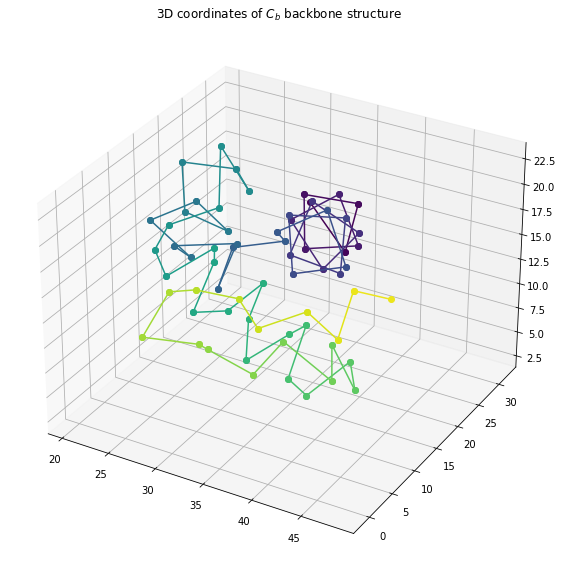

In [6]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,  projection='3d')
ax.set_title('3D coordinates of $C_{b}$ backbone structure')
N = ele['coords'].shape[0]

for i in range(ele['coords'].shape[0] - 1):
    ax.plot(
        xs[i:i+2], ys[i:i+2], zs[i:i+2], 
        color=plt.cm.viridis(i/N),
        marker='o'
    )

## Visualize Distance + Contact Map

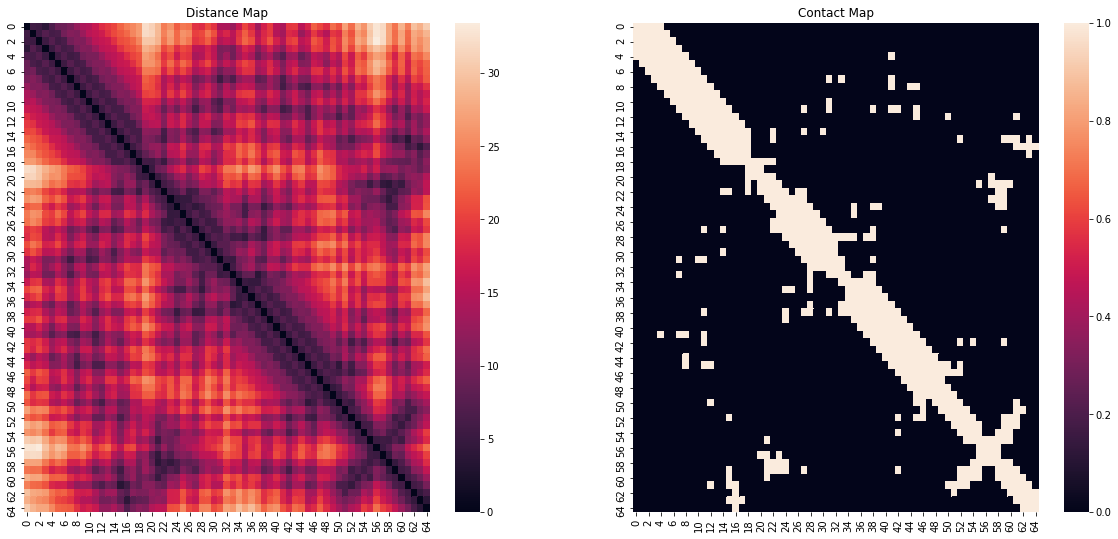

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(20, 9))
sns.heatmap(ele['dist'], ax=ax[0])
sns.heatmap(ele['dist'] < 8, ax=ax[1])
ax[0].set_title('Distance Map')
ax[1].set_title('Contact Map')
plt.show()

## ESM-1b unsupervised self-attention map contact predictions

Note, this matches the `Quickstart` code in the README.

The contact prediction comes from a sparse linear combination of the self-attention maps, trained with logistic regression on a few proteins, as described in our paper "Transformer protein language models are unsupervised structure learners".

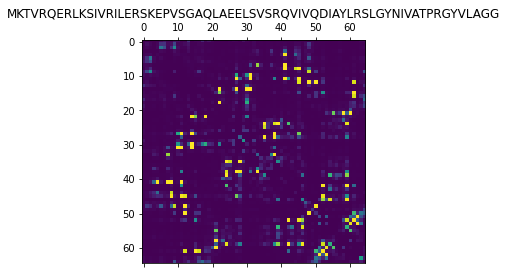

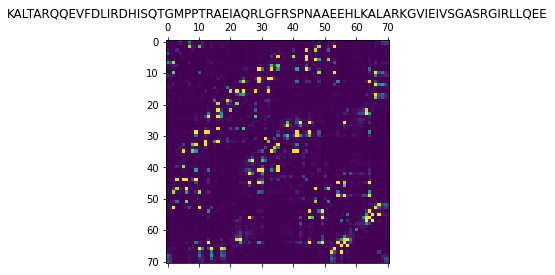

In [8]:
model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()
data = [(i, esm_structural_train[i]['seq']) for i in [0,1]]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
for (_, seq), attention_contacts in zip(data, results["contacts"]):
    plt.matshow(attention_contacts[: len(seq), : len(seq)])
    plt.title(seq)